In [1]:
#!usr/bin/env python 
import dicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os import listdir
from os.path import join
from skimage import filters, measure, morphology

In [2]:
%matplotlib inline

In [3]:
## ---------------------
# SEGMENTATION FUNCTIONS 
## ---------------------

def createVol(list_dcms, path_dcms):
    volCT = np.zeros((512,512,len(list_dcms)))
    for dcm_file in list_dcms:
        path = join(path_dcms, dcm_file)
        dcm = dicom.read_file(path)
        i_no = dcm.InstanceNumber
        housefield_img = dcm.pixel_array*dcm.RescaleSlope + dcm.RescaleIntercept
        volCT[:,:,i_no-1] = housefield_img
    return (volCT)

def otsuMask(vol):
    volBW = np.zeros((vol.shape))
    thresh = filters.threshold_otsu(vol)
    for i in range(vol.shape[2]): 
        volBW[:,:,i] = vol[:,:,i] < thresh
    return volBW

def sliceConCom(volBW):
    volCC = np.zeros((volBW.shape))
    for s in range(volBW.shape[2]): 
        labeled = measure.label(volBW[:,:,s])
        edgeDeleted = deleteEdgeComs(labeled)
        noiseRemoved = removeNoiseComs(edgeDeleted)
        cleanSlice = morphology.binary_closing(noiseRemoved)
        writeSlice(cleanSlice, s)
        volCC[:,:,s] = cleanSlice
    return volCC
    

In [4]:
## ---------------
# HELPER FUNCTIONS
## ---------------

def plotImages(vol):
    fig,ax = plt.subplots(5,5)
    for i in range(5):
        for j in range(5):
            ax[i,j].imshow(vol[:,:,5*(5*i+j)])
            ax[i,j].axis('off')
    plt.rcParams['figure.figsize'] = (30,18)
    
def plotHistogram(vol):
    _ = plt.hist(vol.reshape([-1]), 1000)
    plt.ylim([0,400000])
    plt.plot()

def deleteEdgeComs(labeled):
    edge_1 = labeled[0,:]
    edge_2 = labeled[:,(labeled.shape[0]-1)]
    edge_3 = labeled[:,0]
    edge_4 = labeled[labeled.shape[0]-1,:]
    edgeConCom = list(set(list(edge_1) + list(edge_2) + list(edge_3) + list(edge_4) + [0]))
    for com in edgeConCom: 
        labeled[labeled == com] = 0
    return labeled

def removeNoiseComs(edgeDeleted): # this could really be much more efficient....
    count_dict = {}
    for x in range(edgeDeleted.shape[0]):
        for y in range(edgeDeleted.shape[1]):
            if edgeDeleted[x,y] in count_dict:
                count_dict[edgeDeleted[x,y]] += 1
            else:
                count_dict[edgeDeleted[x,y]] = 1
    noise = []
    for com in count_dict.keys(): 
        if (count_dict[com]) < 100:
            noise.append(com)
    for noiseCom in noise: 
        edgeDeleted[edgeDeleted == noiseCom] = 0 
    return edgeDeleted > 0 

def writeSlice(binSlice, s): 
    plt.imsave(('slice_' + str(s) + '.png'), binSlice, )

In [18]:
def main(): 
    # Define Folder Path
    path_dcms = "/Users/christineyeh/Projects/lung/kaggle_sample_data/0acbebb8d463b4b9ca88cf38431aac69"
    # Load the dcm's
    list_dcms = listdir(path_dcms)
    # Create binary slices
    vol = createVol(list_dcms, path_dcms)
#     plotImages(vol)
    volBW = otsuMask(vol)
    volCC = sliceConCom(volBW)
    plotImages(volCC)

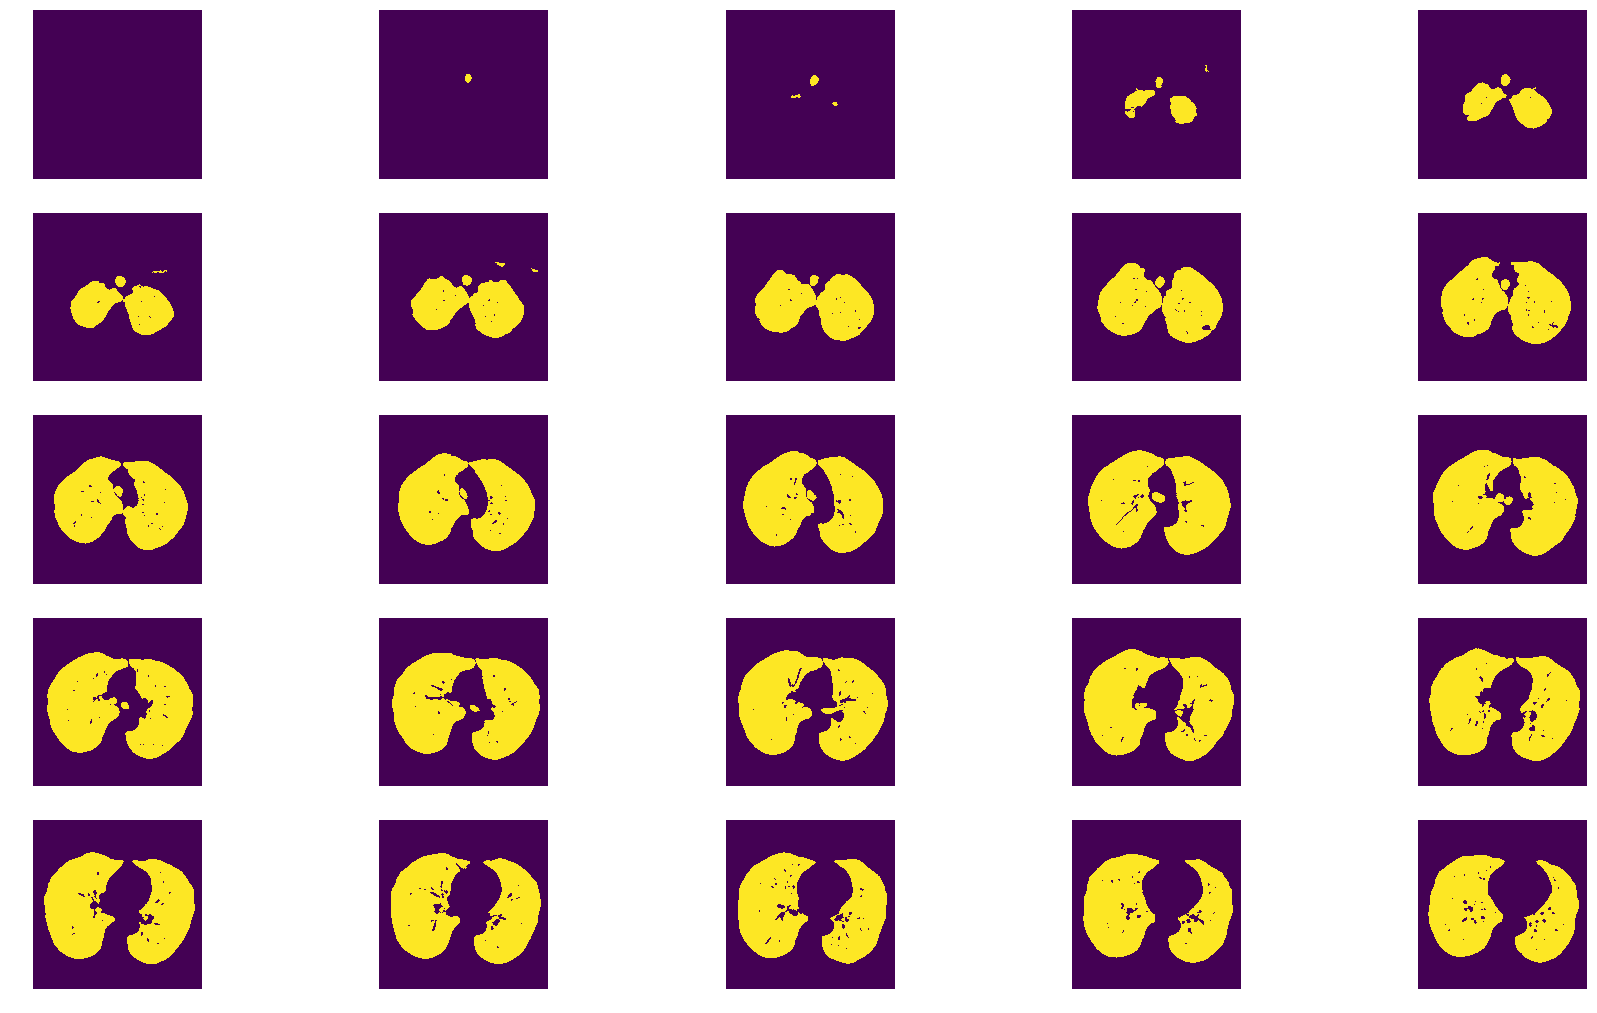

In [20]:
main()